Mounted at /content/drive
CSV already exists – re-using it.

Monthly spend
     month  Total Spend
0  2025-05       802.57

Top-5 spend items / month
      month                      item  price
25  2025-05   Ehrmann Maitorahka 0,2%  30.26
20  2025-05  Bellarom Crema kahvipavu  23.50
56  2025-05  Kot-Kot Vapaan kanan kan  22.14
86  2025-05  Milbona tilsiterviipalee  17.96
24  2025-05  Dunne mini San Marzano 6  15.77

2025-05 – spend by category
  category   price
0    Dairy   77.80
1     Meat   31.61
2    Other  678.96
3   Snacks   14.20

Heaviest 5 items (kg total)
item
Varhaiskaali                4.622
Kurkku Suomi                3.918
Banaani Luomu Reilun kau    3.518
Kukkakaali                  3.444
Ananas                      3.224
Name: weight_kg, dtype: float64


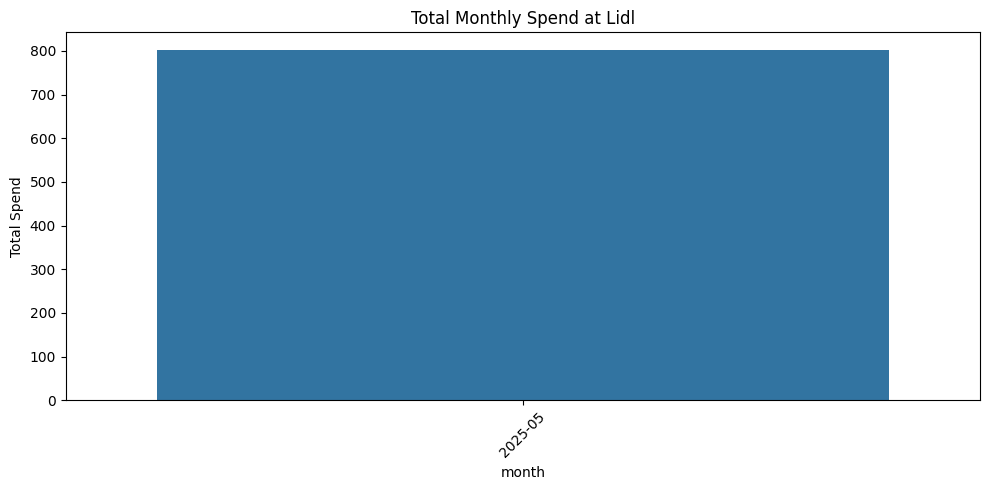

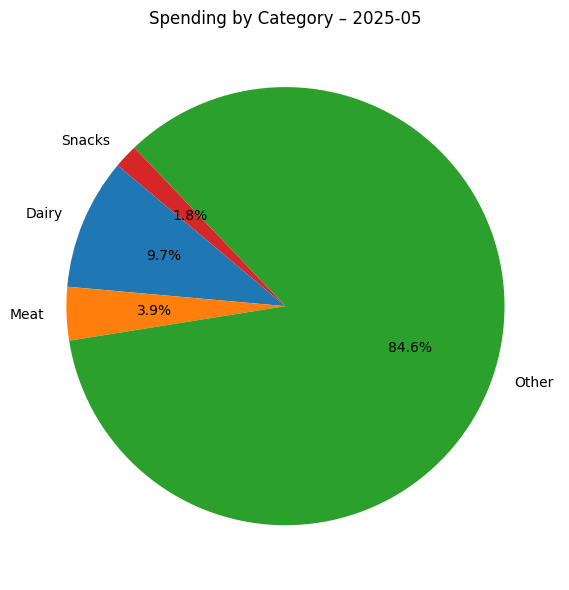

In [2]:
# ================================================================
# Lidl Receipt Analyzer – Google Colab  (Option B weights support)
# ================================================================

# ---------- 1.  Mount Google Drive --------------------------------
from google.colab import drive
drive.mount('/content/drive')

# ---------- 2.  Install OCR runtime once --------------------------
!apt-get install -y tesseract-ocr tesseract-ocr-fin  > /dev/null
!pip -q install pytesseract                          > /dev/null

# ---------- 3.  Imports -------------------------------------------
import pytesseract, re, os, io, cv2, numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ---------- 4.  Category helper -----------------------------------
def categorize(name: str) -> str:
    n = name.lower()
    if any(k in n for k in ('maito', 'juusto', 'rahka')):
        return 'Dairy'
    if any(k in n for k in ('kana', 'liha', 'nakki')):
        return 'Meat'
    if any(k in n for k in ('leipa', 'sämpylä')):
        return 'Bakery'
    if any(k in n for k in ('mehu', 'vesi', 'limu')):
        return 'Drinks'
    if any(k in n for k in ('suklaa', 'makea', 'donitsi')):
        return 'Snacks'
    return 'Other'

# ---------- 5.  Receipt OCR parser  -------------------------------
times        = r'[x×]'   # x or real multiplication sign
q_line_re    = re.compile(rf'^\s*\d+\s*{times}\s*[\d,.]+\s*EUR\b', re.I)
w_line_re    = re.compile(rf'^\s*[\d,.]+\s*kg\s*{times}\s*[\d,.]+\s*EUR/kg\b', re.I)
b_tail       = re.compile(r'\sB\s*$')
skip_words   = ('bonuskuponki', 'lidl plus -säästösi')

def extract_receipt_data(path: str) -> list[dict]:
    # ---- date from filename --------------------------------------------------
    fn = os.path.basename(path)
    m  = re.match(r'(\d{4})\.(\d{2})\.(\d{2})', fn)
    date_guess = f'{m.group(1)}-{m.group(2)}-{m.group(3)}' if m else None

    # ---- OCR -----------------------------------------------------------------
    txt = pytesseract.image_to_string(Image.open(path), lang='fin')
    raw = [l.rstrip() for l in txt.splitlines() if l.strip()]

    # ---- skip header until first “EUR” title ---------------------------------
    body, capture = [], False
    for ln in raw:
        if not capture:
            if 'EUR' in ln:
                capture = True
            continue
        body.append(ln.strip())

    # ---- merge non-B continuation lines --------------------------------------
    blocks = []
    for ln in body:
        if any(w in ln.lower() for w in skip_words):
            continue
        if b_tail.search(ln):
            blocks.append(ln)
        elif blocks:
            blocks[-1] += ' ' + ln

    # ---- add quantity / weight line BELOW description ------------------------
    merged, i = [], 0
    while i < len(blocks):
        cur, nxt = blocks[i], blocks[i + 1] if i + 1 < len(blocks) else ''
        if q_line_re.match(nxt) or w_line_re.match(nxt):
            merged.append(f'{cur} {nxt}'.strip())
            i += 2
        else:
            merged.append(cur)
            i += 1

    # ---- final parse ---------------------------------------------------------
    out = []
    price_re   = re.compile(r'([\d,.]+)\s+B\b')
    q_inline   = re.compile(rf'(\d+)\s*{times}\s*[\d,.]+\s*EUR', re.I)
    w_inline   = re.compile(rf'([\d,.]+)\s*kg\s*{times}\s*[\d,.]+\s*EUR/kg', re.I)

    for ln in merged:
        m = price_re.search(ln)
        if not m:
            continue
        price        = float(m.group(1).replace(',', '.'))
        desc_part    = ln[:m.start()].strip().strip(' "\'')
        tail_part    = ln[m.end():].strip()

        purchase_cnt = 1          # one line on receipt
        item_qty     = 1          # multiplier in “2 × …”
        weight_kg    = None       # NaN for counted goods

        if w := w_inline.search(tail_part):
            weight_kg = float(w.group(1).replace(',', '.'))
        elif q := q_inline.search(tail_part):
            item_qty  = int(q.group(1))

        out.append({
            'item'          : desc_part,
            'price'         : price,
            'purchase_count': purchase_cnt,
            'item_qty'      : item_qty,
            'weight_kg'     : weight_kg,
            'date'          : date_guess
        })
    return out

# ---------- 6.  Batch-process folder ----------------------------------------
def process_receipts_folder(folder: str, csv_out: str) -> pd.DataFrame:
    if os.path.exists(csv_out):
        print('CSV already exists – re-using it.')
        df = pd.read_csv(csv_out)
    else:
        data = []
        for f in os.listdir(folder):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                print('Processing', f)
                data.extend(extract_receipt_data(os.path.join(folder, f)))
        df = pd.DataFrame(data)
        df.to_csv(csv_out, index=False)
        print('Saved →', csv_out)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['category'] = df['item'].apply(categorize)
    return df

# ---------- 7.  Run ----------------------------------------------------------
folder_path = '/content/drive/MyDrive/LidlReceipts'
csv_path    = '/content/drive/MyDrive/lidl_receipts_data.csv'
df = process_receipts_folder(folder_path, csv_path)

# ---------- 8.  Clean + analyse ---------------------------------------------
if df.empty:
    print('No valid data.')
else:
    df = df.dropna(subset=['date']).sort_values('date')
    df['month'] = df['date'].dt.to_period('M').astype(str)

    # --- monthly spend -------------------------------------------------------
    monthly = df.groupby('month')['price'].sum().reset_index(name='Total Spend')

    # --- top expensive items per month --------------------------------------
    top_items = (df.groupby(['month', 'item'])['price'].sum()
                   .reset_index()
                   .sort_values(['month', 'price'], ascending=[True, False])
                   .groupby('month')
                   .head(5))

    # --- category spend in latest month -------------------------------------
    latest_month = monthly['month'].max()
    cat_latest   = (df[df['month'] == latest_month]
                    .groupby('category')['price']
                    .sum()
                    .reset_index())

    # --- extra: total kilograms per item ------------------------------------
    kg_totals = (df.groupby('item')['weight_kg']
                   .sum(min_count=1)     # ignores NaN automatically
                   .dropna()
                   .sort_values(ascending=False)
                   .head(5))

    # --- print summaries -----------------------------------------------------
    print('\nMonthly spend')
    print(monthly)
    print('\nTop-5 spend items / month')
    print(top_items[['month', 'item', 'price']])
    print(f'\n{latest_month} – spend by category')
    print(cat_latest)
    print('\nHeaviest 5 items (kg total)')
    print(kg_totals)

    # --- plots ---------------------------------------------------------------
    plt.figure(figsize=(10,5))
    sns.barplot(data=monthly, x='month', y='Total Spend')
    plt.title('Total Monthly Spend at Lidl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.pie(cat_latest['price'], labels=cat_latest['category'],
            autopct='%1.1f%%', startangle=140)
    plt.title(f'Spending by Category – {latest_month}')
    plt.tight_layout()
    plt.show()


In [4]:
#How to fix a line if needed in data
csv_path = '/content/drive/MyDrive/lidl_receipts_data.csv'

# Load it
df = pd.read_csv(csv_path)
df.at[176, 'price'] = 2.59
print(df.loc[176])
df.to_csv(csv_path, index=False)
print("Saved.")


item              Appelsiini 1,5kg 2:
price                            2.59
purchase_count                      1
item_qty                            1
weight_kg                         NaN
date                       2025-05-07
Name: 176, dtype: object
Saved.


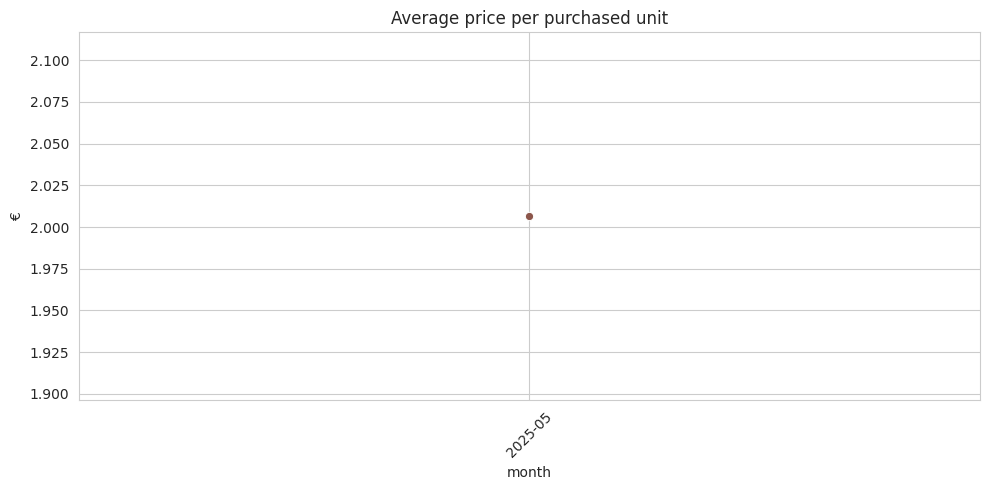

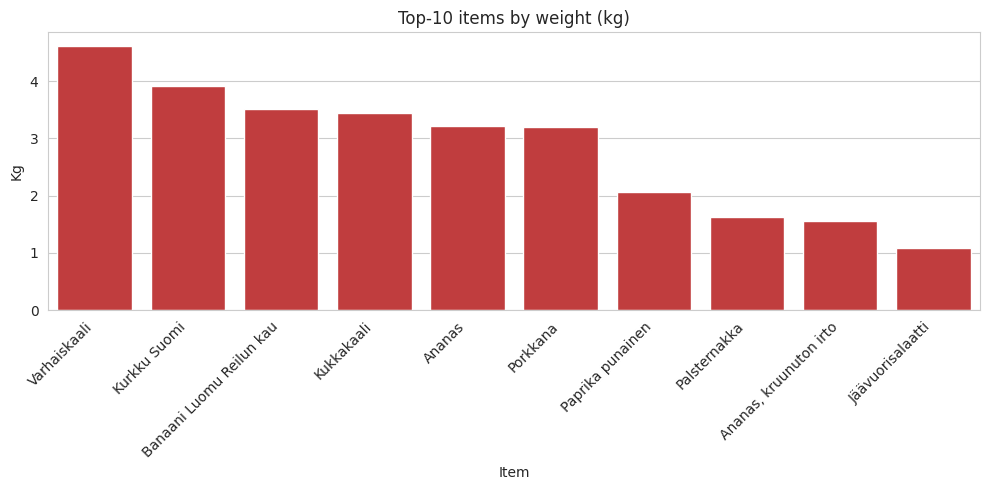

In [46]:
# ------------------------------------------------------------
# 1)  Load & basic tidy
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
csv_path = "/content/drive/MyDrive/lidl_receipts_data.csv"
df = pd.read_csv(csv_path)
# force numeric where it matters
df['item_qty']  = pd.to_numeric(df['item_qty'],  errors='coerce')
df['weight_kg'] = pd.to_numeric(df['weight_kg'], errors='coerce')
df['price']     = pd.to_numeric(df['price'],     errors='coerce')

df['date']  = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['month'] = df['date'].dt.to_period('M')


# =============================================================
# 2) Monthly KPIs   (unchanged)
# =============================================================
monthly = (
    df.groupby('month')
      .agg(
          Spend_eur=('price', 'sum'),
          Units=('item_qty', 'sum'),
          Kg=('weight_kg', 'sum')
      )
      .reset_index()
      .sort_values('month')
)

monthly['Avg_price'] = monthly['Spend_eur'] / monthly['Units']

# =============================================================
# 3)  PLOTTING COPY  ← add these two lines just once
# =============================================================
plot_monthly = monthly.copy()               # keeps original intact
plot_monthly['month'] = plot_monthly['month'].astype(str)   # or .dt.to_timestamp()


# ------------------------------------------------------------
# 3)  Top-10 tables
# ------------------------------------------------------------
monthly['Avg_price'] = monthly['Spend_eur'] / monthly['Units']

plt.figure(figsize=(10, 5))
plot = monthly.copy()
plot['month'] = plot['month'].astype(str)   # e.g. "2025-04"

sns.lineplot(
    data=plot,
    x='month',
    y='Avg_price',          # already computed earlier
    marker='o',
    color='tab:brown'
)
plt.title('Average price per purchased unit')
plt.ylabel('€')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_qty = (df.groupby('item')['item_qty']
             .sum()
             .sort_values(ascending=False)
             .head(10)
             .reset_index(name='Units')        # ← singular
             .rename(columns={'item': 'Item'}))

top_kg  = (df.groupby('item')['weight_kg']
             .sum(min_count=1)
             .sort_values(ascending=False)
             .head(10)
             .reset_index(name='Kg')           # ← singular
             .rename(columns={'item': 'Item'}))

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_kg,
    x='Item',
    y='Kg',
    color='tab:red'
)
plt.title('Top-10 items by weight (kg)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

